In [ ]:
!pip install "ray[default]"
!pip install scikit-learn==1.3.1
!pip install -U ipywidgets
!pip install matplotlib==3.8
!pip install pandas

# Scaling and Distributing Tasks with Ray


Welcome to this interactive notebook! Here, we will explore the challenges associated with hyperparameter tuning for ML models and see how we can simplify and scale this process using Ray. By the end, you will have a clear understanding of how to leverage distributed computing for such tasks.

# Dataset & Model Setup

Let's begin by setting up our environment. We'll use the digits dataset from Scikit-learn and aim to classify the hand-written digits using an SVM (Support Vector Machine). SVMs have several hyperparameters that can significantly influence their performance, making them an ideal candidate for our tuning exercise.

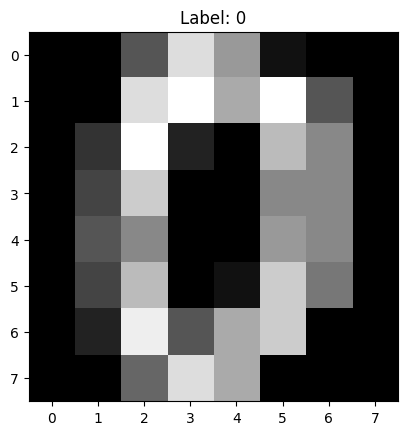

In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load dataset
data = load_digits()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Visualize the dataset
plt.imshow(X[0].reshape(8, 8), cmap='gray')
plt.title(f"Label: {y[0]}")
plt.show()

In [2]:
X[0].shape

(64,)

# Manual Hyperparameter Tuning
Hyperparameter tuning involves training my_trainple models with different hyperparameter values to find the best combination. Let's manually loop over a range of the hyperparameter C for our SVM and see how the performance varies.

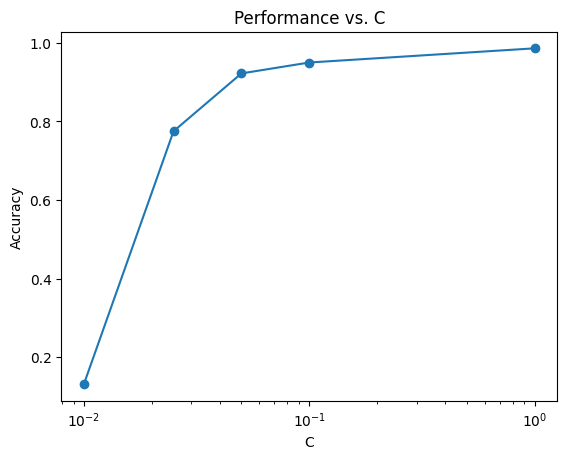

In [3]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


accuracies = []
Cs = [0.01, 0.025, 0.05, 0.1, 1]

for C in Cs:
    clf = SVC(C=C, )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

plt.plot(Cs, accuracies, '-o')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Performance vs. C')
plt.show()

## More parameters to tune.
There other parameters that we can tune in SVM model, you can read more about them [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) in the scikit learn docs.

In [4]:
Cs = [0.01, 0.025, 0.05, 0.1, 1] 
gamma_values = [0.1, 1, 'scale', 'auto']
kernel_values = ['rbf', 'poly']

for C in Cs:
    for gamma in gamma_values:
        for kernel in kernel_values:
            pass

We will have `len(gamma_values) * len(kernel_values) * len(Cs)` training tasks to do, which is a lot! **So let's scale the tasks using ray**.

# Scale Hyperparameter Tuning with Ray
**TODO: rewrite the training code above as a Ray remote function that takes the chosen hpyerparameters as an input**
```
clf = SVC(C=C)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracies.append(accuracy_score(y_test, y_pred))
```

In [5]:
import ray

In [6]:
# TODO: Write a ray function that does the training given the hyperparameters
@ray.remote
def training_task(X_train, X_test, y_train, y_test, C, gamma, kernel):
    clf = SVC(C=C, gamma=gamma, kernel=kernel)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [7]:
address = "ray://3.64.252.42:10001" #"ray://3.79.116.251:10001" # None # Replace the address with the cluster address
ray.init(address, ignore_reinit_error=True)

2023-10-19 11:06:50,699	INFO client_builder.py:243 -- Passing the following kwargs to ray.init() on the server: ignore_reinit_error


Python version:,3.9.16
Ray version:,2.7.1
Dashboard:,http://172.31.17.76:8265


In [9]:
%%time
ref_to_params: {str: tuple} = {}
tasks = []
for C in Cs:
    for gamma in gamma_values:
        for kernel in kernel_values:
            # TODO: Queue the tasks
            task_ref = training_task.remote(X_train, X_test, y_train, y_test, C=C, gamma=gamma, kernel=kernel)
            ref_to_params[task_ref] = (C, gamma, kernel)
            tasks.append(task_ref)
        
params_to_accuracy = {}        
while tasks:
    done_task_ref, tasks = ray.wait(tasks)
    done_task_ref = done_task_ref[0]
    accuracy = ray.get(done_task_ref)
    
    params = ref_to_params[done_task_ref]
    params_to_accuracy[params] = accuracy
    
    # print(f"Task with params {params} is completed, accuarcy = {accuracy}")

CPU times: user 83.4 ms, sys: 51.2 ms, total: 135 ms
Wall time: 1.16 s


In [8]:
def scatter_plot_hyperparameters(params_to_accuracy, hyperparam_names):
    # Assuming params_to_accuracy is a dict where keys are tuples of hyperparameters and values are accuracies
    hyperparams = list(zip(*params_to_accuracy.keys()))
    accuracies = list(params_to_accuracy.values())

    # Create subplots with shared y-axis
    fig, axes = plt.subplots(nrows=1, ncols=len(hyperparam_names), figsize=(15, 5), sharey=True)
    if len(hyperparam_names) == 1:  # Handle the case where there's only one hyperparameter
        axes = [axes]
    
    for ax, hyperparam_values, hyperparam_name in zip(axes, hyperparams, hyperparam_names):
        scatter = ax.scatter([str(x) for x in hyperparam_values], accuracies, c=accuracies, cmap='viridis', edgecolor='k')
        ax.set_xlabel(hyperparam_name)
        ax.set_title(f'{hyperparam_name} vs Accuracy')
    
    axes[0].set_ylabel('Accuracy')
    cbar_ax = fig.add_axes([1.01, 0.15, 0.02, 0.7])  # Adjust the placement of the colorbar to be beside the plots
    fig.colorbar(scatter, cax=cbar_ax)
    plt.tight_layout()
    plt.show()

/var/folders/52/rpqbkh2n0bv0k2n8w03t6r8sv66r61/T/ipykernel_95397/613463139.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


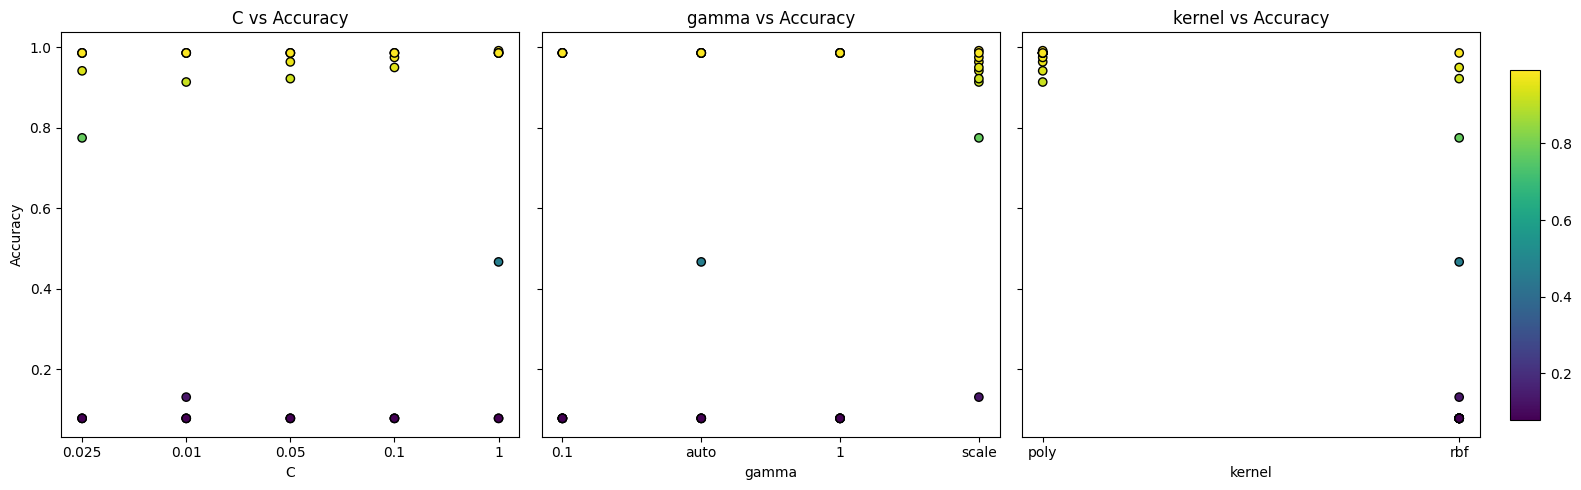

In [12]:
hyperparam_names = ['C', 'gamma', 'kernel']  # Update based on your hyperparameters
scatter_plot_hyperparameters(params_to_accuracy, hyperparam_names)

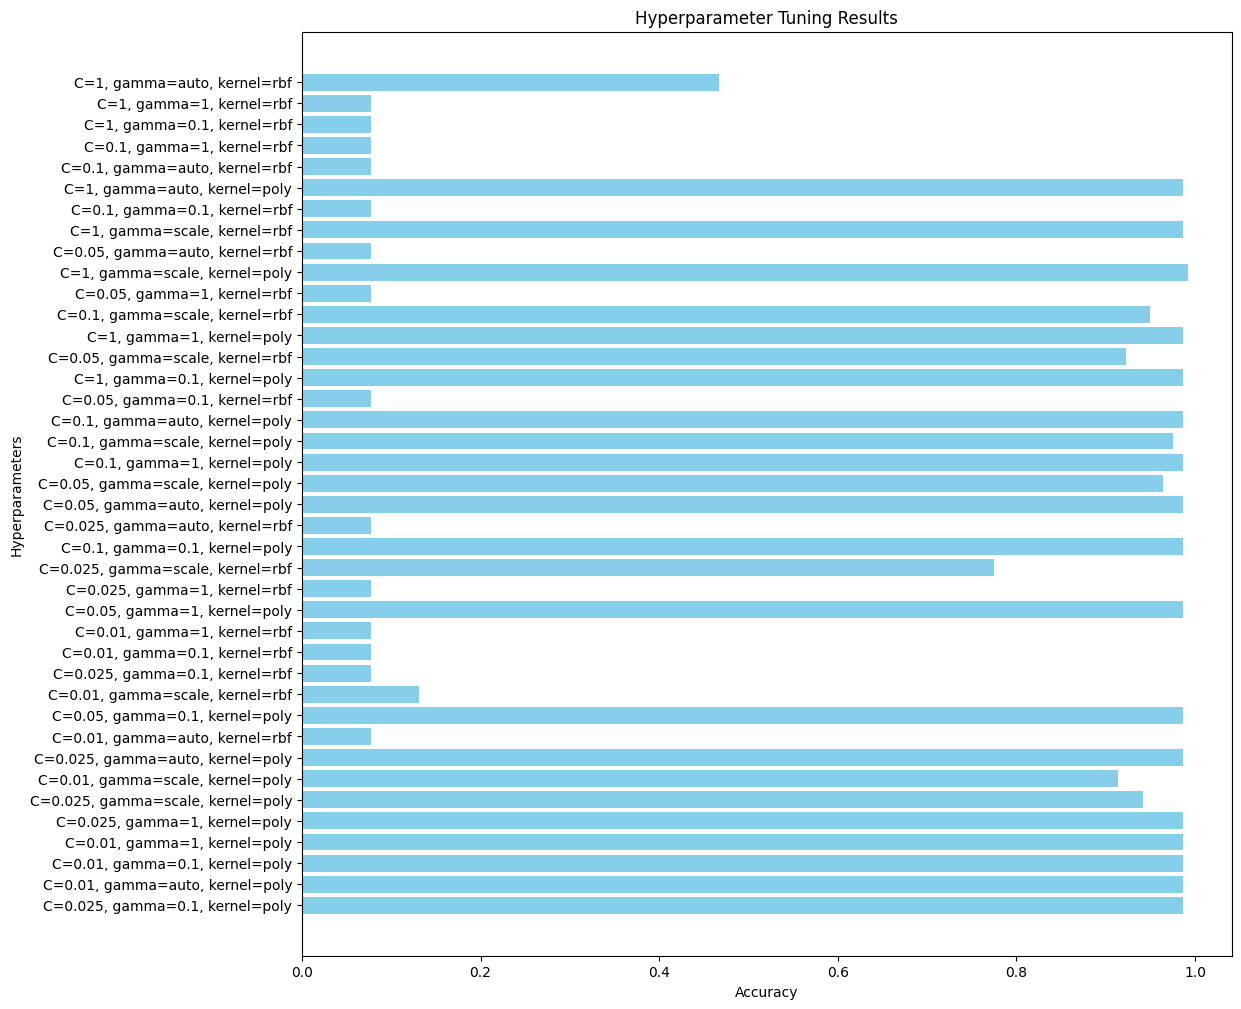

In [13]:
# Extracting values for plotting
hyperparams = list(params_to_accuracy.keys())
accuracies = list(params_to_accuracy.values())

# Create a list of hyperparam strings for x-axis
hyperparam_strings = [f"C={hp[0]}, gamma={hp[1]}, kernel={hp[2]}" for hp in hyperparams]

plt.figure(figsize=(12, 12))
plt.barh(hyperparam_strings, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Hyperparameters')
plt.title('Hyperparameter Tuning Results')
plt.show()


In [ ]:
# Find the hyperparameters with the best accuracy
best_params = max(params_to_accuracy, key=params_to_accuracy.get)
print(f"Best hyperparameters were obtained with:")
print(f"C={best_params[0]}, gamma={best_params[1]}, kernel={best_params[2]}")
print(f"Resulting in an accuracy of: {params_to_accuracy[best_params]}")


Let's compare the speed to **sequential** execution

In [10]:
%%time
for C in Cs:
    for gamma in gamma_values:
        for kernel in kernel_values:
            # TODO: Queue the tasks
            task_ref = training_task.remote(X_train, X_test, y_train, y_test, C=C, gamma=gamma, kernel=kernel)
            ref_to_params[task_ref] = (C, gamma, kernel)
            ray.wait([task_ref])
            accuracy = ray.get(task_ref)

CPU times: user 56.8 ms, sys: 38.4 ms, total: 95.2 ms
Wall time: 4.16 s


# Restart the notebook and replace the Address with the cluster IP

# Optional Exercise: Bigger dataset! 

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

def fetch_and_prepare_mnist_from_csv(file_path, fraction=1.0):
    # Ensure fraction is between 0 and 1
    fraction = max(0.0, min(fraction, 1.0))
    
    # Load the dataset from the CSV file
    data = pd.read_csv(file_path)
    
    # Extract data and target (and scale the data between 0 and 1)
    X = data.iloc[:, 1:].values / 255.0
    y = data.iloc[:, 0].values
    
    # Take the desired fraction of the dataset
    sample_size = int(len(X) * fraction)
    X = X[:sample_size]
    y = y[:sample_size]
    
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

# Example: Fetch 50% of the dataset
# Make sure to provide the correct path to your CSV file in the function below
X_train, X_test, y_train, y_test = fetch_and_prepare_mnist_from_csv('mnist_train.csv', fraction=0.25)
print("Data fetched and prepared!")
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


Data fetched and prepared!
Training data shape: (11999, 784)
Test data shape: (3000, 784)


In [10]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Label: 8')

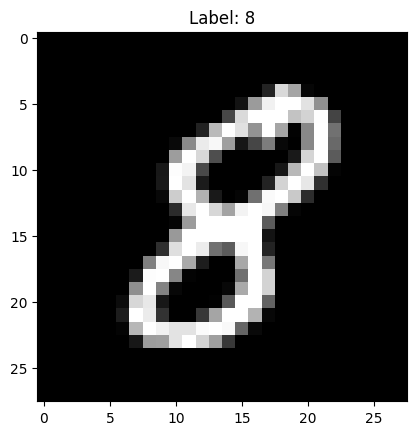

In [12]:
plt.imshow(X_train[0].reshape(28, 28), cmap='gray')
plt.title(f"Label: {y_train[0]}")

## Sending the dataset everytime is costly!
Ray provide a way to send a refernce of an object to have a better performance, so let's put the datasets in a refernce

In [13]:
%%time
X_train_ref, X_test_ref, y_train_ref, y_test_ref = ray.put(X_train), ray.put(X_test), ray.put(y_train), ray.put(y_test)

ref_to_params: {str: tuple} = {}
tasks = []
for C in Cs:
    for gamma in gamma_values:
        for kernel in kernel_values:
            # TODO: Queue the tasks
            task_ref = training_task.remote(X_train_ref, X_test_ref, y_train_ref, y_test_ref, C=C, gamma=gamma, kernel=kernel)
            ref_to_params[task_ref] = (C, gamma, kernel)
            tasks.append(task_ref)
        
params_to_accuracy = {}        
while tasks:
    done_task_ref, tasks = ray.wait(tasks)
    done_task_ref = done_task_ref[0]
    accuracy = ray.get(done_task_ref)
    
    params = ref_to_params[done_task_ref]
    params_to_accuracy[params] = accuracy
    
    # print(f"Task with params {params} is completed, accuarcy = {accuracy}")

(autoscaler +21s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +21s) Resized to 42 CPUs.
CPU times: user 2.56 s, sys: 2.58 s, total: 5.14 s
Wall time: 7min 54s
(autoscaler +10m42s) Removing 2 nodes of type ray.worker.default (idle).
(autoscaler +10m48s) Removing 1 nodes of type ray.worker.default (idle).
(autoscaler +10m53s) Resized to 38 CPUs.
(autoscaler +10m58s) Resized to 36 CPUs.
(autoscaler +11m4s) Removing 2 nodes of type ray.worker.default (idle).
(autoscaler +11m14s) Resized to 32 CPUs.
(autoscaler +11m20s) Removing 2 nodes of type ray.worker.default (idle).
(autoscaler +11m30s) Resized to 28 CPUs.
(autoscaler +11m30s) Removing 1 nodes of type ray.worker.default (idle).
(autoscaler +11m41s) Resized to 26 CPUs.
(autoscaler +11m41s) Removing 1 nodes of type ray.worker.default (idle).
(autoscaler +11m46s) Removing 3 nodes of type ray.worker.default (idle).
(autoscaler +11m52s) Resized to 24 CPUs.
(autosc

In [ ]:
hyperparam_names = ['C', 'gamma', 'kernel']  # Update based on your hyperparameters
scatter_plot_hyperparameters(params_to_accuracy, hyperparam_names)

In [ ]:
# Extracting values for plotting
hyperparams = list(params_to_accuracy.keys())
accuracies = list(params_to_accuracy.values())

# Create a list of hyperparam strings for x-axis
hyperparam_strings = [f"C={hp[0]}, gamma={hp[1]}, kernel={hp[2]}" for hp in hyperparams]

plt.figure(figsize=(12, 12))
plt.barh(hyperparam_strings, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Hyperparameters')
plt.title('Hyperparameter Tuning Results')
plt.show()


## MLP with MNIST


In [ ]:
from sklearn.neural_network import MLPClassifier

@ray.remote
def mlp_training_task(X_train, X_test, y_train, y_test, hidden_layer, activation, solver, alpha, learning_rate):
    
    clf = MLPClassifier(
        hidden_layer_sizes=hidden_layer, activation=activation, 
        solver=solver, alpha=alpha, 
        learning_rate=learning_rate, max_iter=1000,  # added for convergence
        random_state=42
    )
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    return accuracy

In [ ]:
# Hyperparameter values/ranges for tuning
hidden_layer_sizes = [(50,), (100,), (50, 30)]
activations = ['logistic', 'tanh', 'relu']
# solvers = ['lbfgs', 'sgd', 'adam']
alphas = [0.0001, 0.001, 0.01]
learning_rates = ['constant', 'invscaling', 'adaptive']

# Loop over hyperparameters
ref_to_params = {}
tasks = []

for hidden_layer in hidden_layer_sizes:
    for activation in activations:
        for alpha in alphas:
            for lr in learning_rates:
                task_ref = mlp_training_task.remote(X_train_ref, X_test_ref, y_train_ref, y_test_ref, hidden_layer, activation, 'sgd', alpha, lr)
                ref_to_params[task_ref] = (hidden_layer, activation, alpha, lr)
                tasks.append(task_ref)

# Retrieve and print results
params_to_accuracy = {}
while tasks:
    done_task_ref, tasks = ray.wait(tasks)
    done_task_ref = done_task_ref[0]
    accuracy = ray.get(done_task_ref)
    
    params = ref_to_params[done_task_ref]
    params_to_accuracy[params] = accuracy

In [ ]:
hyperparam_names = ['hidden_layer', 'activation', 'alpha', 'lr']  # Update based on your hyperparameters
scatter_plot_hyperparameters(params_to_accuracy, hyperparam_names)


In [ ]:
# Extracting values for plotting
hyperparams = list(params_to_accuracy.keys())
accuracies = list(params_to_accuracy.values())

# Create a list of hyperparam strings for x-axis
# (hidden_layer, activation, solver, alpha, lr)
hyperparam_strings = [f"hidden_layer={hp[0]}, activation={hp[1]},\nalpha={hp[2]}, lr={hp[3]}" for hp in hyperparams]

plt.figure(figsize=(10, 20))
plt.barh(hyperparam_strings, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Hyperparameters')
plt.title('Hyperparameter Tuning Results')
plt.show()


In [ ]:
# Find the hyperparameters with the best accuracy
best_params = max(params_to_accuracy, key=params_to_accuracy.get)
print(f"Best hyperparameters were obtained with:")
print(f"C={best_params[0]}, gamma={best_params[1]}, kernel={best_params[2]}")
print(f"Resulting in an accuracy of: {params_to_accuracy[best_params]}")
